# Climate Analysis

### Import all necessary packages and configue SQLAlchemy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt

In [2]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, and_

In [3]:
# Create Engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# Declare a base
Base = automap_base()

In [5]:
Base.prepare(engine, reflect=True)

In [6]:
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign measurement and station classes to variables
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create session
session = Session(engine)

#### Use inspector to see what columns we will be working with

In [9]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], ' : ', c['type'])

id  :  INTEGER
station  :  TEXT
date  :  TEXT
prcp  :  FLOAT
tobs  :  FLOAT


In [11]:
columns2 = inspector.get_columns('station')
for c in columns2:
    print(c['name'], ' : ', c['type'])

id  :  INTEGER
station  :  TEXT
name  :  TEXT
latitude  :  FLOAT
longitude  :  FLOAT
elevation  :  FLOAT


### Engine execute to select datapoints

In [26]:
engine.execute("SELECT * FROM station LIMIT 10;").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

### Query data to store into variable to use for analysis.

#### Find the last 12 months of percipitation data (very confused what output graph is supposed to represent)

#### Answer overwrites dates as it sees the same index. For example... 8-24-16 comes up 8 times... only the last one gets plotted.

In [27]:
measurement_results = session.query(measurement.date, measurement.station, measurement.prcp).\
    filter(measurement.date > dt.datetime(year=2016, month=8, day=23)).\
    order_by(measurement.date).all()

In [30]:
measurement_df = pd.DataFrame(measurement_results, columns=['date', 'station', 'precipitation'])
measurement_df.set_index('date', inplace=True)
measurement_df.head()

# Data points are not unique according to date. 

,station,precipitation
date,,
2016-08-24,USC00519397,0.08
2016-08-24,USC00513117,2.15
2016-08-24,USC00514830,2.28
2016-08-24,USC00517948,NaN
2016-08-24,USC00519523,1.22


In [41]:
station_id = "USC00519397"

prcp_byStation = measurement_df.loc[measurement_df['station'] == station_id]

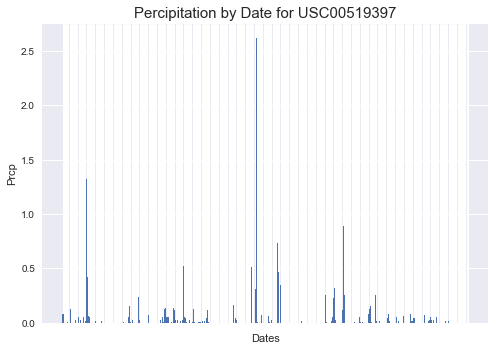

In [48]:
fig, ax = plt.subplots()

dates = list(prcp_byStation.index.values)

ax.bar(dates, prcp_byStation['precipitation'])

ax.set_xlabel("Dates")
ax.set_xticklabels("")
ax.set_ylabel("Prcp")
ax.set_title(f"Percipitation by Date for {station_id}", fontsize=15)

plt.show()

#### Station Analysis

In [15]:
station_count = session.query(func.count(station.station))
for row in station_count:
    print(f"There are {row[0]} stations in the station table")

There are 9 stations in the station table


#### Most Active Stations!

In [16]:
station_active = session.query(measurement.station, func.count(measurement.date)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.date).desc()).all()


In [17]:
for row in station_active:
    print(row[0], row[1])

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


#### Last 12 months of temp observations for station with most activity

In [18]:
# sub query the station with the highest results. (output is the station with the most activity in the specified 12 months.)
sub_query = session.query(measurement.station).\
    filter(measurement.date > dt.datetime(year=2016, month=8, day=23)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id)).first()

sub_query[0]

'USC00517948'

In [19]:
sel = [measurement.station, measurement.tobs, measurement.date]
active_station_temp = session.query(*sel).\
    filter(and_(measurement.station == sub_query[0], measurement.date > dt.datetime(year=2016, month=8, day=23))).\
    order_by(measurement.date).all()

In [20]:
active_station_df = pd.DataFrame(active_station_temp, columns=['station', 'temp', 'date'])
active_station_df.set_index('station', inplace=True)
len(active_station_df.index)

182

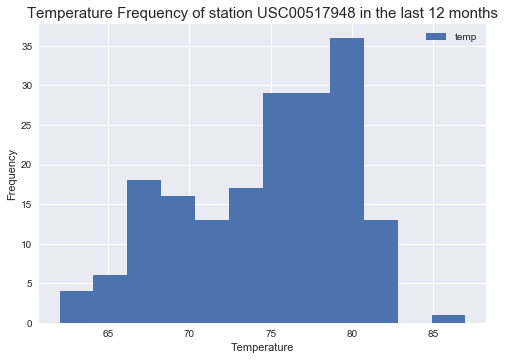

In [21]:
plt.style.use('seaborn')

fig, ax=plt.subplots()
ax.hist(x = active_station_df['temp'], bins=12, label='temp')
ax.set_xlabel("Temperature")
ax.set_ylabel("Frequency")
ax.set_title(f"Temperature Frequency of station {active_station_df.index[0]} in the last 12 months", fontsize=15)
plt.legend()
plt.show()

#### Note: this is not an exact match of the graph from the directions, but the above graph follows instruction and is the histogram plot of temperatures from the station with the most recorded values. 

## Temperature Analysis

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# trip date will be from march 1st - 8th 2018... hypothetically 
print(calc_temps('2017-03-01', '2017-03-08'))

[(62.0, 70.77083333333333, 78.0)]


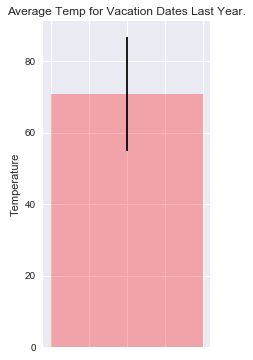

In [49]:
vaca_temps = calc_temps('2017-03-01', '2017-03-08')
vaca_temps = vaca_temps[0]
fig, ax=plt.subplots(figsize=(3,6))
yerr_bar = vaca_temps[2]-vaca_temps[0]

ax.bar(x=0, height=vaca_temps[1], yerr=yerr_bar, alpha=.3, color='r', width=1)
ax.set_xticklabels(labels="")
ax.set_ylabel("Temperature")
ax.set_title(f"Average Temp for Vacation Dates Last Year.")

plt.show()

# Part 2: API route using Flask

### Can be found on the .py file